### Raymundo Gonzalez Leal
### CS156:  Machine Learning Fashionista

Here we make a linear classifier to differentiate between male and female clothing

In [80]:
from PIL import Image
import PIL.ImageOps
from collections import defaultdict
from glob import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import pandas as pd
import re
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

Note: The original dataset had many poor images (showing multiple people, some of them males and some of them females). Hence I first manually chose a subset of the images, about 500 of them, that seemed appropriate for the task of classifying male and female clothes.

In [3]:
# this is the size of all the Target.com images
STANDARD_SIZE = (100,100)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)
def img_to_array(filename):
    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]
man_files = glob('CleanMan/*')
woman_files = glob('CleanWoman/*')

In [268]:
process_file = img_to_array
raw_data = [(process_file(filename),'man',filename) 
            for filename in man_files] + \
           [(process_file(filename),'woman',filename) 
            for filename in woman_files]

In [5]:
X = [i[0] for i in raw_data ]
y  = [1 if i[1] == 'man' else 0 for i in raw_data ]

In [272]:
# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=1)

### Linear Model on original data

In [163]:
clf = LinearSVC()
clf.fit(X_train,y_train)
y_train_hat = clf.predict(X_train)
print metrics.classification_report(y_train,y_train_hat)
print metrics.accuracy_score(y_train,y_train_hat)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       231
          1       1.00      1.00      1.00       219

avg / total       1.00      1.00      1.00       450

1.0


In [164]:
y_val_hat = clf.predict(X_val)
print metrics.classification_report(y_val,y_val_hat)
print metrics.accuracy_score(y_val,y_val_hat)

             precision    recall  f1-score   support

          0       0.55      0.58      0.56        60
          1       0.49      0.45      0.47        53

avg / total       0.52      0.52      0.52       113

0.522123893805


We clearly are overfitting, as we have a perfect fit for training data and poor results on validation. Let's use our validation set to see if we can create a better model. We will try this both on a Logistic Regression classifier, and on an SVC. We will use the regularization parameter C (smaller values of C impose a harsher regularization penalty).

In [252]:
CList = [1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]

SVCAcc = []
LogRegAcc = []

for C in CList:
    clf1 = LinearSVC(C = C)
    clf2 = LogisticRegression(C = C)
    clf1.fit(X_train,y_train)
    clf2.fit(X_train,y_train)
    y_val_hat = clf1.predict(X_val)
    SVCAcc.append(metrics.accuracy_score(y_val,y_val_hat))
    y_val_hat = clf2.predict(X_val)
    LogRegAcc.append(metrics.accuracy_score(y_val,y_val_hat))

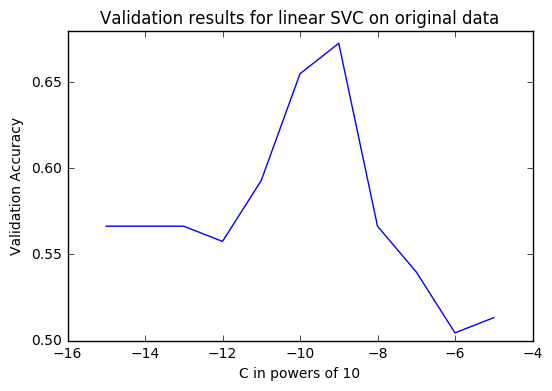

In [255]:
plt.plot([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5],SVCAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for linear SVC on original data")
plt.show()

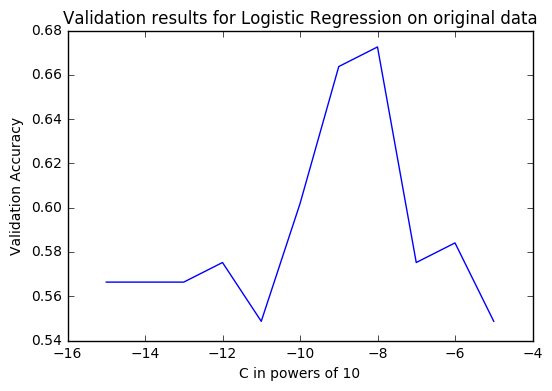

In [256]:
plt.plot([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5],LogRegAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for Logistic Regression on original data")
plt.show()

Hence we seem to be able to obtain about 0.67 validation accuracy using a linear model on our original data once we use appropriate regularization to prevent overfitting.

### Linear Model on PCA features

First I will cross validate the number of components I want to use from PCA.

In [233]:
Accuracy_list = []
clf = LogisticRegression()
for components in range(1,100):
    pca = PCA(n_components= components, random_state=0)
    PCAX_train = pca.fit_transform(X_train)
    PCAX_test = pca.transform(X_test)
    
    clf.fit(PCAX_train,y_train)
    y_test_hat = clf.predict(PCAX_test)
    
    Accuracy_list.append(metrics.accuracy_score(y_test,y_test_hat))

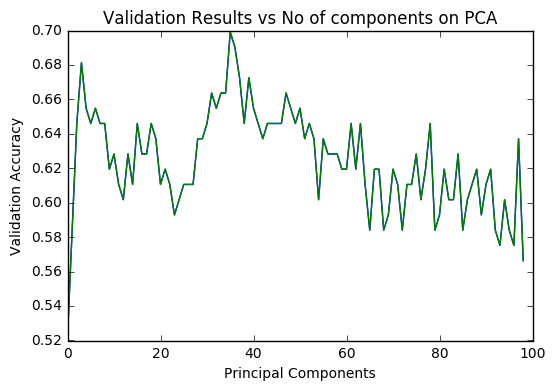

In [258]:
plt.plot(Accuracy_list)
plt.xlabel("Principal Components")
plt.ylabel("Validation Accuracy")
plt.title("Validation Results vs No of components on PCA")
plt.show()

In [241]:
# find the principal components
N_COMPONENTS = 37
pca = PCA(n_components=N_COMPONENTS, svd_solver = 'full')
PCAX_train = pca.fit_transform(X_train)
PCAX_val = pca.transform(X_val)

In [242]:
clf.fit(PCAX_train,y_train)
PCAy_train_hat = clf.predict(PCAX_train)
print metrics.classification_report(y_train,PCAy_train_hat)
print metrics.accuracy_score(y_train,PCAy_train_hat)

             precision    recall  f1-score   support

          0       0.70      0.74      0.72       231
          1       0.71      0.66      0.68       219

avg / total       0.70      0.70      0.70       450

0.702222222222


In [243]:
PCAy_val_hat = clf.predict(PCAX_val)
print PCAy_val_hat[0]
print metrics.classification_report(y_val,PCAy_val_hat)
print metrics.accuracy_score(y_val,PCAy_val_hat)

1
             precision    recall  f1-score   support

          0       0.69      0.78      0.73        60
          1       0.71      0.60      0.65        53

avg / total       0.70      0.70      0.70       113

0.699115044248


Now I will try to improve these results using the same number of Principal Components but using different values for our regularization parameter C.

In [259]:
CList = [1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]

SVCAcc = []
LogRegAcc = []

for C in CList:
    clf1 = LinearSVC(C = C)
    clf2 = LogisticRegression(C = C)
    clf1.fit(PCAX_train,y_train)
    clf2.fit(PCAX_train,y_train)
    y_val_hat = clf1.predict(PCAX_val)
    SVCAcc.append(metrics.accuracy_score(y_val,y_val_hat))
    y_val_hat = clf2.predict(PCAX_val)
    LogRegAcc.append(metrics.accuracy_score(y_val,y_val_hat))

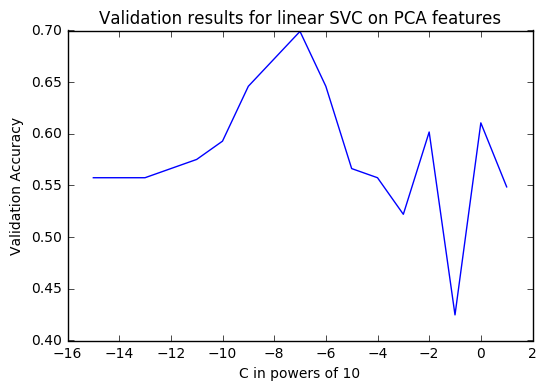

In [262]:
plt.plot([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1],SVCAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for linear SVC on PCA features")
plt.show()

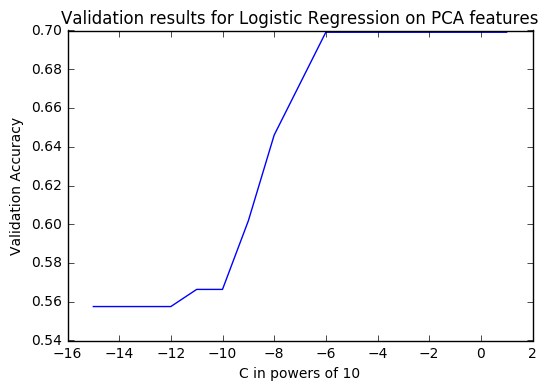

In [263]:
plt.plot([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1],LogRegAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for Logistic Regression on PCA features")
plt.show()

Seems like 0.70 is our maximum validation accuracy with this approach. This is not a great improvement from our best results with our simple linear model on original data. However, we are able to obtain these results with less than 40 features instead of our whole resized image, which is pretty neat.

### Linear Model on LDA features

In [128]:
LDA = LinearDiscriminantAnalysis( n_components = 1)
LDAX_train = LDA.fit_transform(X_train,y_train)
LDAX_val = LDA.transform(X_val)

In [156]:
clf = LogisticRegression()
clf.fit(LDAX_train,y_train)
LDAy_train_hat = clf.predict(LDAX_train)
print metrics.classification_report(y_train,LDAy_train_hat)
print metrics.accuracy_score(y_train,LDAy_train_hat)

             precision    recall  f1-score   support

          0       0.91      0.91      0.91       231
          1       0.90      0.90      0.90       219

avg / total       0.90      0.90      0.90       450

0.904444444444


In [157]:
LDAy_val_hat = clf.predict(LDAX_val)
print metrics.classification_report(y_val,LDAy_val_hat)
print metrics.accuracy_score(y_val,LDAy_val_hat)

             precision    recall  f1-score   support

          0       0.57      0.55      0.56        60
          1       0.51      0.53      0.52        53

avg / total       0.54      0.54      0.54       113

0.53982300885


Again, we are overfitting. Let's see if we can correct this by changing our regularization parameter C. We'll test this with both of our classifiers.

In [264]:
CList = [1e-30,1e-25,1e-20,1e-15,1e-10,1e-5,1]

SVCAcc = []
LogRegAcc = []

for C in CList:
    clf1 = LinearSVC(C = C)
    clf2 = LogisticRegression(C = C)
    clf1.fit(LDAX_train,y_train)
    clf2.fit(LDAX_train,y_train)
    LDAy_val_hat = clf1.predict(LDAX_val)
    SVCAcc.append(metrics.accuracy_score(y_val,LDAy_val_hat))
    LDAy_val_hat = clf2.predict(LDAX_val)
    LogRegAcc.append(metrics.accuracy_score(y_val,LDAy_val_hat))

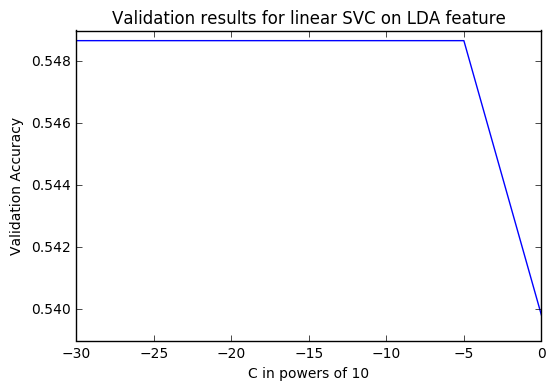

In [266]:
plt.plot([-30,-25,-20,-15,-10,-5,0],SVCAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for linear SVC on LDA feature")
plt.show()

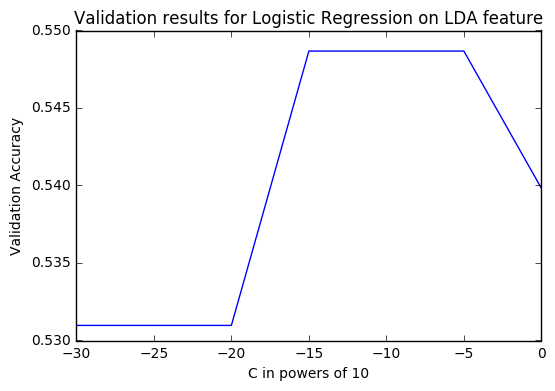

In [267]:
plt.plot([-30,-25,-20,-15,-10,-5,0],LogRegAcc)
plt.xlabel("C in powers of 10")
plt.ylabel("Validation Accuracy")
plt.title("Validation results for Logistic Regression on LDA feature")
plt.show()

We see that our validation accuracy for both classifiers changes less when we change C, as compared to what we observed in our linear models without LDA. I think this makes intuitive sense, as we have only 1 predictor in our LDA models (because we can have as many features as our number of classes minus 1). If we have very little predictors, in this case 1, then it makes sense that there are less model choices that will have an impact on our results. LDA seeks to create a transformation of our data that facilitates classification. However, because we have only two classes, LDA is limited to using just 1 predictor, and hence it does not achieve better results than our simple linear model on our original data.